In [174]:
import numpy as np
import matplotlib.pyplot as plt
import random
import timeit
import ciw
import collections
import seaborn as sbr
import pandas as pd

# Define the model

![model](imgs/visualised_model.png)

In [175]:
def build_model(lambda_a, lambda_o, mu, total_capacity):
    """ Builds the required ciw network

    Parameters
    ----------
    lambda_a : [float]
        [Arrival rate of ambulance patients]
    lambda_o : [float]
        [Arrival rate of other patients]
    mu : [float]
        [Service rate of hospital]
    total_capacity : [integer]
        [The total capacity of the hospital]
    """          
    model = ciw.create_network(
        arrival_distributions = [ciw.dists.Exponential(lambda_a),
                                 ciw.dists.Exponential(lambda_o)],
        service_distributions = [ciw.dists.Deterministic(0),
                                 ciw.dists.Exponential(mu)],
        routing=[[0.0, 1.0],
                 [0.0, 0.0]],
        number_of_servers=[float('inf'), total_capacity]
    )
    return model

# Inherit 'ciw.Node' class to block individuals of Node 1

![smart_model](imgs/visualised_smart_model.png)

In [176]:
def build_custom_node(threshold=8):
    """Build a custome node to replace the default ciw.Node
    
    Parameters
    ----------
    threshold : [int], optional
        [The capacity threshold to be used by the method, by default 8]
    
    Returns
    -------
    [class]
        [A custom node class that inherits from ciw.Node]
    """    
    class CustomNode(ciw.Node):
        def finish_service(self):
            """
            The next individual finishes service:
              - finds the individual to finish service
              - check if they need to change class
              - find their next node
              - release the individual if there is capacity at destination,
                otherwise cause blockage
              - note that blockage also occurs when we are at node 1 and the 
                number of individuals on node 2 are more than the 'thershold'
            """
            next_individual, next_individual_index = self.find_next_individual()
            self.change_customer_class(next_individual)
            next_node = self.next_node(next_individual)
            next_individual.destination = next_node.id_number

            if not np.isinf(self.c):
                next_individual.server.next_end_service_date = float('Inf')
            
            blockage = (next_node.number_of_individuals > threshold and self.id_number == 1)
            if (next_node.number_of_individuals < next_node.node_capacity) and not blockage:
                self.release(next_individual_index, next_node)
                # print(self.id_number, next_node.number_of_individuals)
            else:
                self.block_individual(next_individual, next_node)
                # print(next_node.number_of_individuals)
    return CustomNode

# Simulate the problem

In [177]:
def simulate_model(lambda_a, lambda_o, mu, total_capacity, threshold = 8, seed_num = None):
    """Simulate the model
    
    Parameters
    ----------
    seed_num : [float], optional
        [A seed number in order to be able to replicate results], by default random.random()
    
    Returns
    -------
    [object]
        [An object that contains all simulation records]
    """    
    if seed_num == None:
        seed_num = random.random()
        
    model = build_model(lambda_a, lambda_o, mu, total_capacity)
    node = build_custom_node(threshold)

    ciw.seed(seed_num)
    
    simulation = ciw.Simulation(model, node_class=node)
    simulation.simulate_until_max_time(1440)
    
    return simulation

In [178]:
lambda_a = 0.1       # Ambulance: 6 arrivals per hour
lambda_o = 0.05      # Others: 3 arrivals per hour
mu = 0.05            # Service time: 3 services per hour
total_capacity = 8   # Number of servers: 8 servers
threshold = 4        # Threshold of accepting ambulance patients

records = simulate_model(lambda_a, lambda_o, mu, total_capacity, threshold, 1).get_all_records()
blocks = [b.time_blocked for b in records]
np.mean(blocks)

0.4184074029967902

# Timing Experiment 1

In [179]:
def get_trial_duration(lambda_a, lambda_o, mu, total_capacity, threshold, trials, repeat_trial):
    parameters = [lambda_a, lambda_o, mu, total_capacity, threshold]
    timeit_string = "simulate_model("
    for par in range(len(parameters)):
        timeit_string += str(parameters[par]) + ","
    timeit_string += ")"
    duration_object = timeit.Timer(timeit_string, "from __main__ import simulate_model")
    duration_of_trial = duration_object.repeat(repeat=repeat_trial, number=trials)
    return duration_of_trial


def save_to_file(duration):
    with open("Custom_Trials.txt", "a") as textfile:
        textfile.write(str(duration) + "\n")

def time_for_different_number_of_trials(lambda_a, lambda_o, mu, total_capacity, threshold, num_of_trials, repeat_trial=1, method='Simulation'):
    if method == 'Simulation':        
        open('Custom_Trials.txt', 'w').close()
        times = []
        for trials in range(num_of_trials):
            duration = get_trial_duration(lambda_a, lambda_o, mu, total_capacity, threshold, trials, repeat_trial)
            times.append(duration)
            save_to_file(duration)     
    return times

In [180]:
def get_distribution_plot(times, kind=None):
    times_to_plot = []
    step = int(np.ceil(len(times) / 20))
    index = []
    for i in range(1, len(times), step):
        times_to_plot.append(times[i])
        for j in range(len(times[i])):
            index.append(i)
    
    times_to_plot = np.matrix(times_to_plot).flatten().transpose()
    times_df = pd.DataFrame({'Number of trials': index})
    times_df["Time in seconds"] = times_to_plot
    if kind == "violin":
        time_plot = sbr.violinplot(x='Number of trials', y='Time in seconds', kind="box", data=times_df)
    elif kind == "box":
        time_plot = sbr.catplot(x='Number of trials', y='Time in seconds', kind="box", data=times_df, aspect=2.5)
    else:
        time_plot = sbr.catplot(x='Number of trials', y='Time in seconds', data=times_df, aspect=2.5)

    return time_plot


def get_all_lines_plot(times):
    time_plot = plt.plot(times)
    time_plot = plt.xlabel("Number of Trials")
    time_plot = plt.ylabel("Time in seconds")
    return time_plot


def get_mean_plot(times):
    time_plot = plt.plot([np.mean(t) for t in times])
    time_plot = plt.xlabel("Number of Trials")
    time_plot = plt.ylabel("Time in seconds")
    return time_plot

In [181]:
# Queueing Parameters
lambda_a = 0.1       # Ambulance: 6 arrivals per hour
lambda_o = 0.05      # Others: 3 arrivals per hour
mu = 0.05            # Service time: 3 services per hour
total_capacity = 8   # Number of servers: 8 servers
threshold = 4        # Threshold of accepting ambulance patients

# Timing Experiment parameters
num_of_trials = 500      # Number of trials to be considered
repetition = 15           # Repetition of each trial
method = "Simulation"     # Method to be used (only Simulation available)

times = time_for_different_number_of_trials(lambda_a, lambda_o, mu, total_capacity, threshold, num_of_trials, repetition, method)

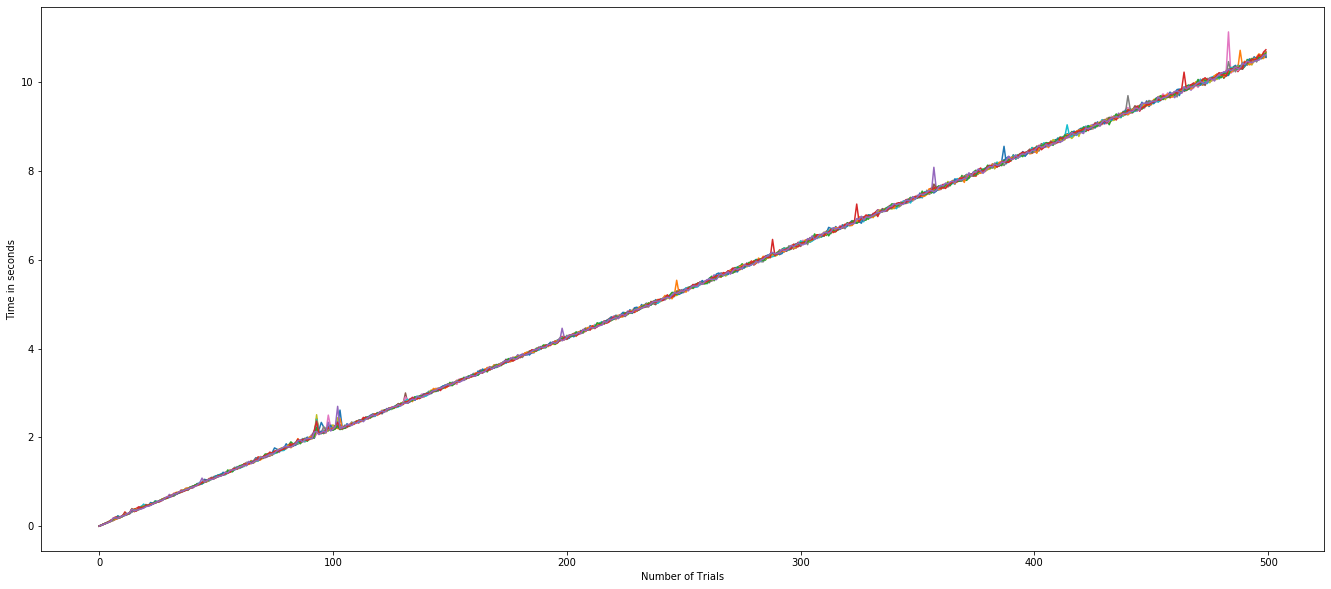

In [182]:
plt.figure(figsize=(23,10))
get_all_lines_plot(times)
plt.show()

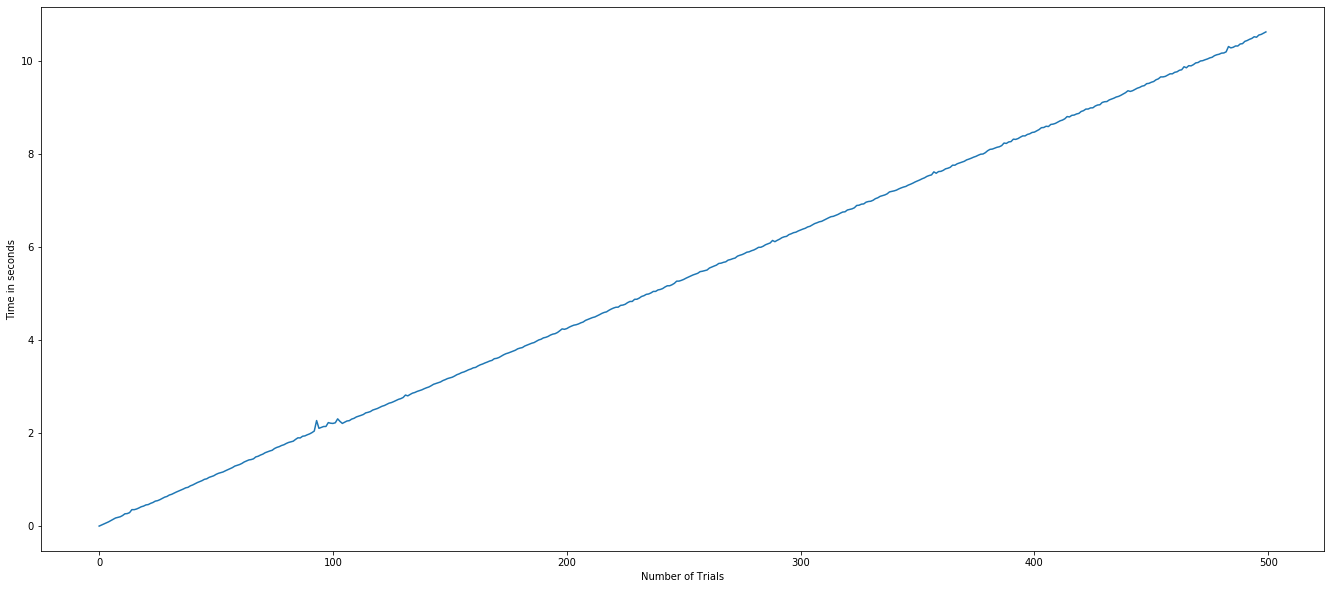

In [183]:
plt.figure(figsize=(23,10))
get_mean_plot(times)
plt.show()

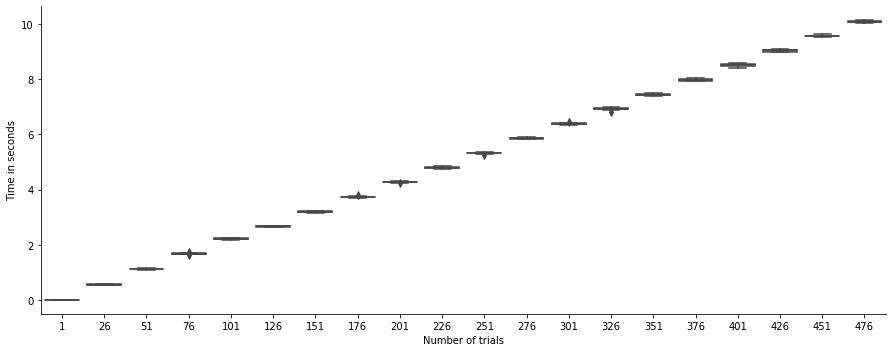

In [184]:
get_distribution_plot(times, kind="box")
plt.show()

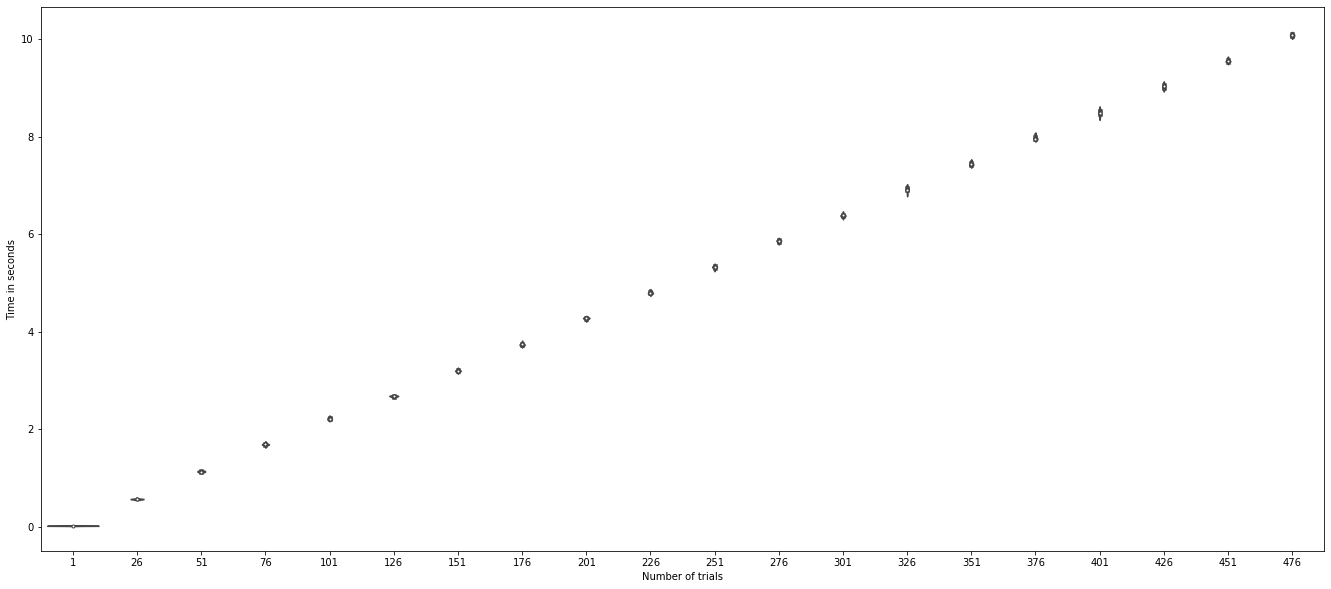

In [185]:
plt.figure(figsize=(23,10))
get_distribution_plot(times, kind="violin")
plt.show()

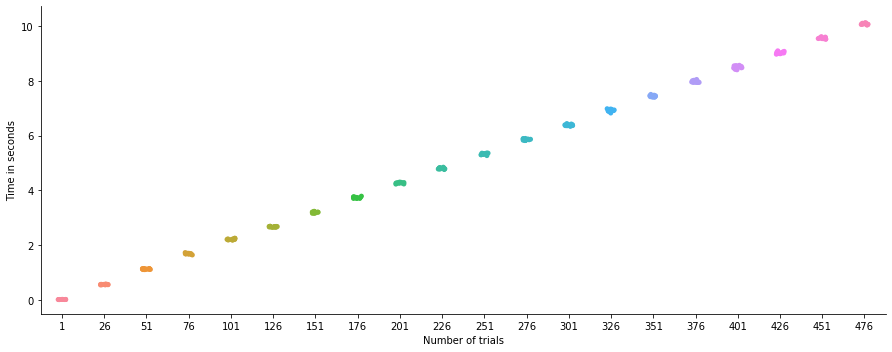

In [186]:
get_distribution_plot(times)
plt.show()

# Timing Experiment 2 - Investigate convergence of times

In [187]:
def get_multiple_runs_results(lambda_a, lambda_o, mu, total_capacity, threshold, num_of_trials=10):
    
    warm_up_time = 100
    records = collections.namedtuple('records', 'waiting_times service_times blocking_times')
    results = []
    
    for trial in range(num_of_trials):
        simulation = simulate_model(lambda_a, lambda_o, mu, total_capacity, threshold, random.random())
        sim_results = simulation.get_all_records()

        waiting = [r.waiting_time for r in sim_results if r.arrival_date > warm_up_time]
        serving = [r.service_time for r in sim_results if r.arrival_date > warm_up_time]
        blocking = [r.time_blocked for r in sim_results if r.arrival_date > warm_up_time]

        results.append(records(waiting, serving, blocking))
        
    return results

In [188]:
def results_for_different_number_of_trials(lambda_a, lambda_o, mu, total_capacity, threshold, num_of_trials = 10):
      
    results = get_multiple_runs_results(0.15, 0.2, 0.05, 8, 4, num_of_trials)
    
    all_waits = [w.waiting_times for w in results]
    all_services = [s.service_times for s in results]
    all_blocks = [b.blocking_times for b in results]
    
    return [all_waits, all_services, all_blocks]
    
    
def get_distributions_over_time(all_times):

    mean_times = []
    step = int(np.ceil(len(all_times) / 20))
    aggregated_times = [[] for _ in range(int(np.ceil(num_of_trials/step)))]
    plot_labels = []
    list_pos = 0
    
    for times in range(len(all_times)):
        mean_times.append(np.mean(all_times[times]))
        if times % step == 0:
            plot_labels.append(times)
            aggregated_times[list_pos] += mean_times
            list_pos += 1
    
    aggregated_times = aggregated_times[0:20]
    return [aggregated_times, plot_labels]



def make_plot_of_confidence_intervals(all_times, time_type=None):
    
    aggregated_times, plot_labels = get_distributions_over_time(all_times)
    if time_type == 'w':
        title = "Mean Waiting time over number of iterations"
    elif time_type == 's':
        title = "Mean Service time over number of iterations"
    elif time_type == 'b':
        title = "Mean time Blocked over number of iterations"
    else:
        title = " "
    
    plt.figure(figsize=(23,10))
    plot = plt.boxplot(aggregated_times, showfliers = True, labels = plot_labels)
    plt.title(title)
    plt.xlabel('Number of trials')
    plt.ylabel('Means of times')
    
    return plot

In [197]:
# Queueing Parameters
lambda_a = 0.1       # Ambulance: 6 arrivals per hour
lambda_o = 0.05      # Others: 3 arrivals per hour
mu = 0.05            # Service time: 3 services per hour
total_capacity = 8   # Number of servers: 8 servers
threshold = 4        # Threshold of accepting ambulance patients

# Timing Parameters
num_of_trials = 1000

In [198]:
time_results = results_for_different_number_of_trials(lambda_a, lambda_o, mu, total_capacity, threshold, num_of_trials)

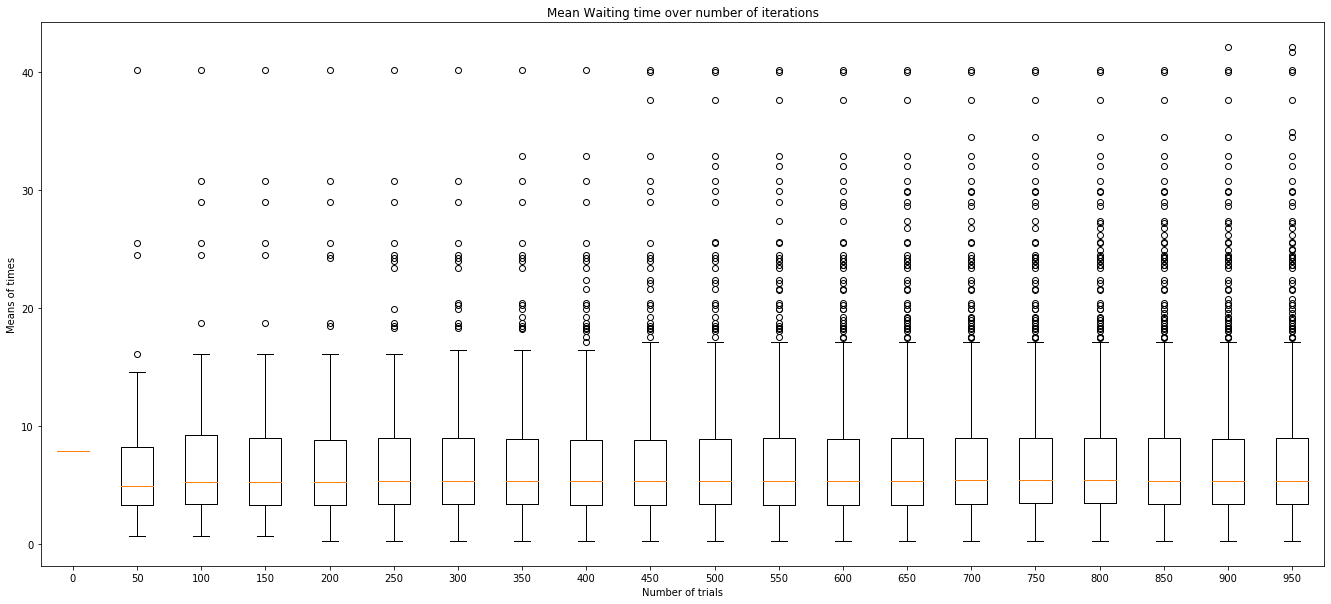

In [199]:
make_plot_of_confidence_intervals(time_results[0], time_type="w")
plt.show()

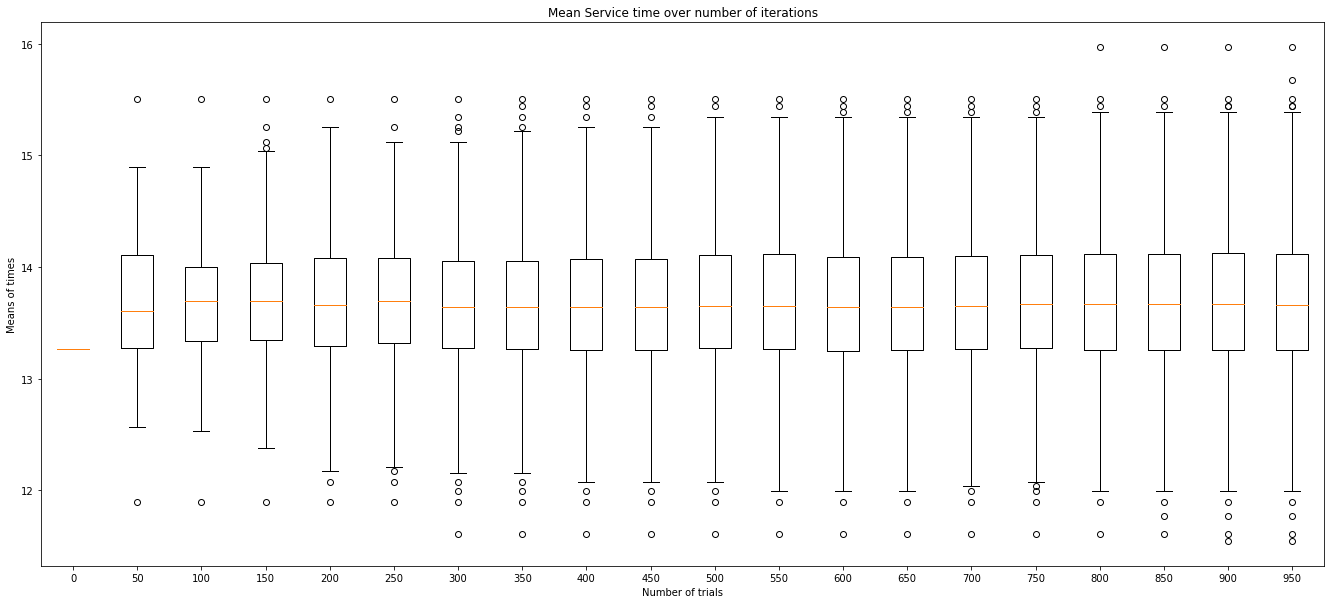

In [200]:
make_plot_of_confidence_intervals(time_results[1], time_type="s")
plt.show()

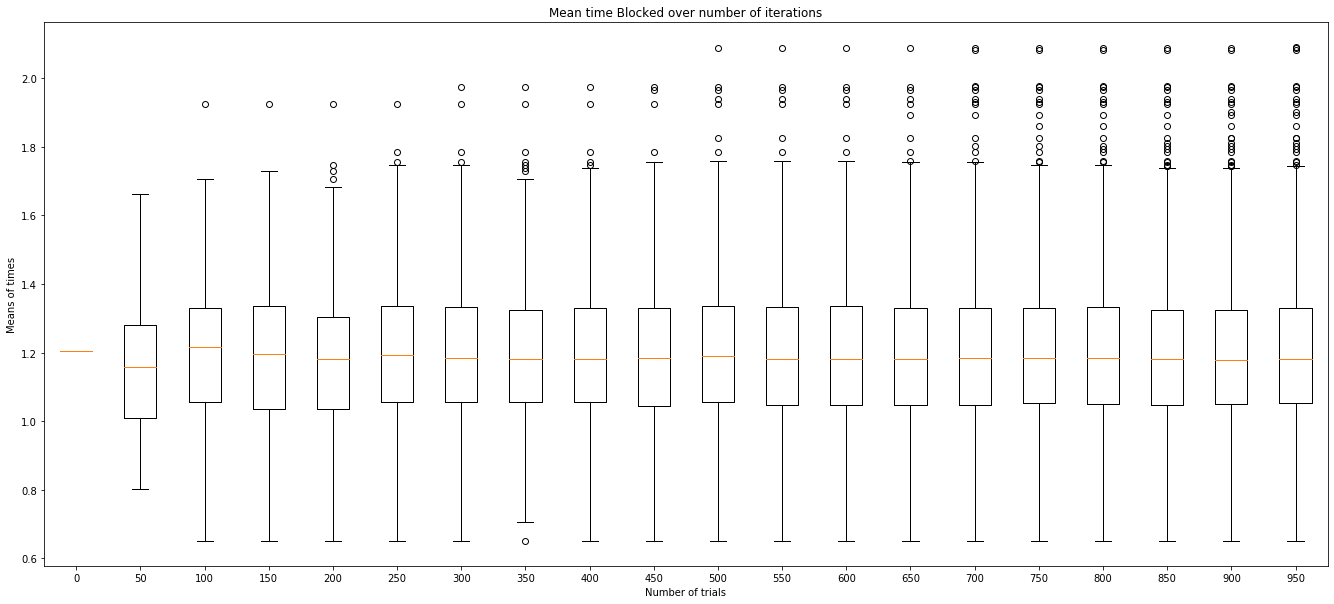

In [201]:
make_plot_of_confidence_intervals(time_results[2], time_type="b")
plt.show()

# Plots of the model

In [168]:
simulation = simulate_model(lambda_a, lambda_o, mu, total_capacity, 100, 1)
sim_results = simulation.get_all_records()
waits = [r.waiting_time for r in sim_results]
blocks = [r.time_blocked for r in sim_results]
w_b = waits + blocks
mean_waiting_time = sum(w_b) / len(w_b)
mean_waiting_time

0.004774821168119709

# Results of the model

In [127]:
# Queueing Parameters
lambda_a = 0.1       # Ambulance: 6 arrivals per hour
lambda_o = 0.05      # Others: 3 arrivals per hour
mu = 0.05            # Service time: 3 services per hour
total_capacity = 8   # Number of servers: 8 servers
threshold = 4        # Threshold of accepting ambulance patients

In [25]:
simulation = simulate_model(lambda_a, lambda_o, mu, total_capacity, threshold, 1)
sim_results = simulation.get_all_records()

In [26]:
# Mean Waiting Time
waits = [r.waiting_time for r in sim_results]
mean_waiting_time = sum(waits) / len(waits)
mean_waiting_time

0.009549642336239419

In [27]:
# Services in each node
service_nodes = [r.node for r in sim_results]
collections.Counter(service_nodes)

Counter({1: 152, 2: 224})

In [205]:
# Mean Time Blocked
Blocks = [r.time_blocked for r in sim_results]
mean_time_blocked = sum(Blocks) / len(Blocks)
mean_time_blocked

1.401489260432193

In [321]:
results = get_multiple_runs_results(lambda_a, lambda_o, mu, total_capacity, 4, 1)

print(np.mean([np.mean(w.waiting_times) for w in results]))
print(np.mean([np.mean(s.service_times) for s in results]))
print(np.mean([np.mean(b.blocking_times) for b in results]))

0.024603351099810346
12.099666641700496
0.6746981848352325


# Timing Experiment 2 - (Confidence Intervals)

In [ ]:
def waiting_time_confidence_intervals_for_different_number_of_trials(trials_to_be_checked = 10):

    all_waiting_times = [[] for _ in range(trials_to_be_checked)]
    for number_of_trials in range(trials_to_be_checked):
        results = get_multiple_runs_results(0.15, 0.2, 0.05, 8, 4, number_of_trials)
        current_waiting_times = [w.waiting_times for w in results]

        for wait in range(len(current_waiting_times)):
            all_waiting_times[number_of_trials] += current_waiting_times[wait]
        
    return all_waiting_times

demo = waiting_time_confidence_intervals_for_different_number_of_trials(20)

plt.boxplot(demo, whis = 1, showfliers = False)
plt.show()

# Examples for testing

In [170]:
ciw.seed(5)
Q = ciw.Simulation(build_model(1, 1, 2, 1))

Q.simulate_until_max_time(100)
records = Q.get_all_records()
waits = [r.waiting_time for r in records]
blocks = [r.time_blocked for r in records]

print(len(records))
print(sum(waits))
print(sum(blocks))

290
1089.854729732795
0.0


In [171]:
ciw.seed(5)
Q = ciw.Simulation(build_model(1, 1, 2, 1), node_class=build_custom_node(7))

Q.simulate_until_max_time(100)
records = Q.get_all_records()
waits = [r.waiting_time for r in records]
blocks = [r.time_blocked for r in records]

print(len(records))
print(sum(waits))
print(sum(blocks))

290
1040.318433783405
52.00679633745028


In [172]:
sim_results = []
for i in range(10):
    simulation = simulate_model(0.15, 0.2, 0.05, 8, 4, i)
    sim_results.append(len(simulation.get_all_records()))

In [173]:
sim_results

[699, 719, 759, 715, 703, 719, 695, 685, 775, 719]

# Dummy Cells

In [ ]:
def build_model2(lambda_a, lambda_o, mu, total_capacity):
    """ Builds the required ciw network

    Parameters
    ----------
    lambda_a : [float]
        [Arrival rate of ambulance patients]
    lambda_o : [float]
        [Arrival rate of other patients]
    mu : [float]
        [Service rate of hospital]
    total_capacity : [integer]
        [The total capacity of the hospital]
    """          
    model = ciw.create_network(
        arrival_distributions = [ciw.dists.Exponential(lambda_a),
                                 ciw.dists.Exponential(lambda_o)],
        service_distributions = [ciw.dists.Deterministic(0),
                                 ciw.dists.Exponential(mu)],
        routing=[[0.0, 1.0],
                 [0.0, 0.0]],
        number_of_servers=[float('inf'), total_capacity]
    )
    return model